In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("day.csv")
print(df.shape)
df.head()

(730, 16)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


day.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


There are no null values, and hence imputation is not needed.

In [4]:
# making the mappings using the data dictionary
df['dteday'] = pd.to_datetime(df['dteday'])
df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df['yr'] = df['yr'].map({0: 2018, 1:2019})
df['weathersit'] = df['weathersit'].map({1:"clear", 2:"mist", 3:"light_rain", 4:"heavy_rain"})

In [5]:
# Data Leakage - dropping 'casual' and 'registered' since using these two alone predictions can be made.
df.drop(['casual', 'registered'], axis=1, inplace=True)

In [6]:
# also dropping 'instant' (index), since it does not add any value to the analysis
df.drop(['instant'], axis=1, inplace=True)

In [7]:
df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,2018-01-01,spring,2018,1,0,6,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,2018-02-01,spring,2018,1,0,0,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,2018-03-01,spring,2018,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,2018-04-01,spring,2018,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,2018-05-01,spring,2018,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,1600


### Data Checks

In [8]:
df.sample(30)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
658,2019-10-21,winter,2019,10,0,0,0,clear,19.030847,22.82145,51.0000,11.125618,6824
464,2019-10-04,summer,2019,4,0,2,1,clear,18.313347,21.81165,43.5000,16.708125,5918
122,2018-03-05,summer,2018,5,0,2,1,mist,25.283347,29.10395,69.7083,22.958689,4451
542,2019-06-27,fall,2019,6,0,3,1,clear,28.597500,32.03960,36.0000,18.208925,7335
88,2018-03-30,summer,2018,3,0,3,1,mist,12.300000,14.86750,64.6667,11.583496,1536
608,2019-01-09,fall,2019,9,0,6,0,mist,30.886653,35.13270,63.8333,7.583529,6140
404,2019-09-02,spring,2019,2,0,4,1,clear,10.865000,13.09940,56.2083,13.000479,3830
55,2018-02-25,spring,2018,2,0,5,1,mist,14.938268,17.52305,71.2174,23.218113,1461
478,2019-04-24,summer,2019,4,0,2,1,clear,16.946653,20.26415,45.4167,16.708661,5633
653,2019-10-16,winter,2019,10,0,2,1,clear,19.201653,23.04230,55.8333,12.208807,7534


In [9]:
df['weathersit'].value_counts()

clear         463
mist          246
light_rain     21
Name: weathersit, dtype: int64

There is 'heavy_rain' category missing, but not much we can do about it.

In [10]:
df['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

There seems to be an issue in 'weekday' and 'mnth'. They are inaccurate for some values. Let's use the date column to create the features. 

In [11]:
# # using the previous assignment which starts with Sunday (as 0)
df['weekday'] = ((df['dteday'].dt.dayofweek+1)%7)

# # let's also derive year and month from datetime
df['yr'], df['mnth'] = df['dteday'].dt.year, df['dteday'].dt.month

In [12]:
# let's also verify all weekends are holidays
df.loc[df['weekday'].isin([0, 6]), 'holiday'].value_counts()

0    201
1      7
Name: holiday, dtype: int64

In [13]:
df.loc[df['weekday'].isin([0, 6]), 'workingday'].value_counts()

1    153
0     55
Name: workingday, dtype: int64

### Derive new features 'day_of_month' and 'is_extended_weekend'

In [14]:
# let's create a new variable - is_extended_weekend

df = df.sort_values(by='dteday').reset_index(drop=True)
df['is_extended_weekend'] = 0

# convert Monday holidays and the weekends before to extended weekend
extended_monday_index = df.loc[(df['holiday']==1)&(df['weekday']==1)].index
print("Extended Monday Index:")
print(extended_monday_index)
for idx in extended_monday_index:
    df['is_extended_weekend'].iloc[[idx-2, idx-1, idx]] = 1

# similarly, convert Friday holidays and the weekends after to extended weekend
extended_friday_index = df.loc[(df['holiday']==1)&(df['weekday']==5)].index
print("Extended Friday Index:")
print(extended_friday_index)
for idx in extended_friday_index:
    df['is_extended_weekend'].iloc[[idx, idx+1, idx+2]] = 1

print(df['is_extended_weekend'].value_counts())
df.loc[df['is_extended_weekend']==1]

Extended Monday Index:
Int64Index([], dtype='int64')
Extended Friday Index:
Int64Index([396, 690], dtype='int64')
0    724
1      6
Name: is_extended_weekend, dtype: int64


C:\Users\nkothapalli\Miniconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,is_extended_weekend
396,2019-02-01,spring,2019,2,1,5,0,clear,11.194763,12.61520,38.1304,22.087555,1951,1
397,2019-02-02,spring,2019,2,0,6,1,mist,16.365847,19.94855,67.2917,12.541529,3761,1
398,2019-02-03,spring,2019,2,0,0,1,mist,14.486653,17.99210,65.7083,9.708568,3194,1
690,2019-11-22,winter,2019,11,1,5,0,clear,13.940000,17.51855,58.0417,3.542344,2425,1
691,2019-11-23,winter,2019,11,0,6,1,clear,15.101653,18.93895,56.8750,9.917407,3910,1
692,2019-11-24,winter,2019,11,0,0,0,clear,11.411653,12.43710,40.4583,25.250357,2277,1


In [15]:
df['day_of_month'] = df['dteday'].dt.day

### Drop Date column

In [16]:
# since we have extracted the features from date column, let's drop it
df.drop(['dteday'], axis=1, inplace=True)

In [17]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,is_extended_weekend,day_of_month
0,spring,2018,1,0,1,0,mist,14.110847,18.18125,80.5833,10.749882,985,0,1
1,spring,2018,1,0,2,1,mist,7.879134,11.72650,82.9565,3.565271,1360,0,2
2,spring,2018,1,0,3,1,clear,10.933347,13.19395,53.5000,14.500475,1851,0,3
3,summer,2018,1,0,4,1,mist,12.300000,14.17270,68.6250,17.333436,2227,0,4
4,summer,2018,1,0,5,0,mist,18.518347,22.41020,76.2083,7.125718,3351,0,5


### Create Dummy Variables

In [18]:
df = pd.get_dummies(df, drop_first=True)

## Model Building and Evaluation

In [19]:
df_ = df.copy()

y = df_.pop('cnt')
X = df_

### train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, shuffle=True, test_size=0.2)

cols = X_train.columns
### scaling
scaler = MinMaxScaler()
X_train[cols] = scaler.fit_transform(X_train)
X_test[cols] = scaler.transform(X_test)

C:\Users\NKOTHA~1\AppData\Local\Temp/ipykernel_17740/2812911998.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cols] = scaler.fit_transform(X_train)
C:\Users\nkothapalli\Miniconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\NKOTHA~1\AppData\Local\Temp/ipykernel_17740/2812911998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [20]:
X_train

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,is_extended_weekend,day_of_month,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
176,0.0,0.454545,0.0,0.333333,0.0,0.773634,0.733185,0.527849,0.106327,0.0,0.833333,0.0,0.0,0.0,0.0,0.0
172,0.0,0.454545,0.0,0.833333,1.0,0.840090,0.806955,0.727506,0.274549,0.0,0.700000,0.0,0.0,0.0,0.0,0.0
142,0.0,0.363636,0.0,0.500000,1.0,0.713409,0.671054,0.832905,0.407822,0.0,0.733333,0.0,1.0,0.0,0.0,1.0
237,0.0,0.636364,0.0,0.000000,1.0,0.798555,0.762199,0.782776,0.083449,0.0,0.833333,0.0,0.0,0.0,0.0,0.0
531,1.0,0.454545,0.0,0.000000,0.0,0.713409,0.676845,0.518424,0.262440,0.0,0.500000,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1.0,0.000000,0.0,1.000000,1.0,0.690564,0.653628,0.678234,0.239562,0.0,0.133333,0.0,1.0,0.0,0.0,1.0
320,0.0,0.909091,0.0,1.000000,1.0,0.352054,0.320482,0.592116,0.562608,0.0,0.533333,0.0,0.0,1.0,0.0,1.0
527,1.0,0.454545,0.0,0.500000,1.0,0.245101,0.235138,0.523136,0.279942,0.0,0.366667,0.0,0.0,1.0,0.0,0.0
125,0.0,0.363636,0.0,0.000000,0.0,0.734175,0.705849,0.670951,0.201896,0.0,0.166667,0.0,1.0,0.0,0.0,1.0


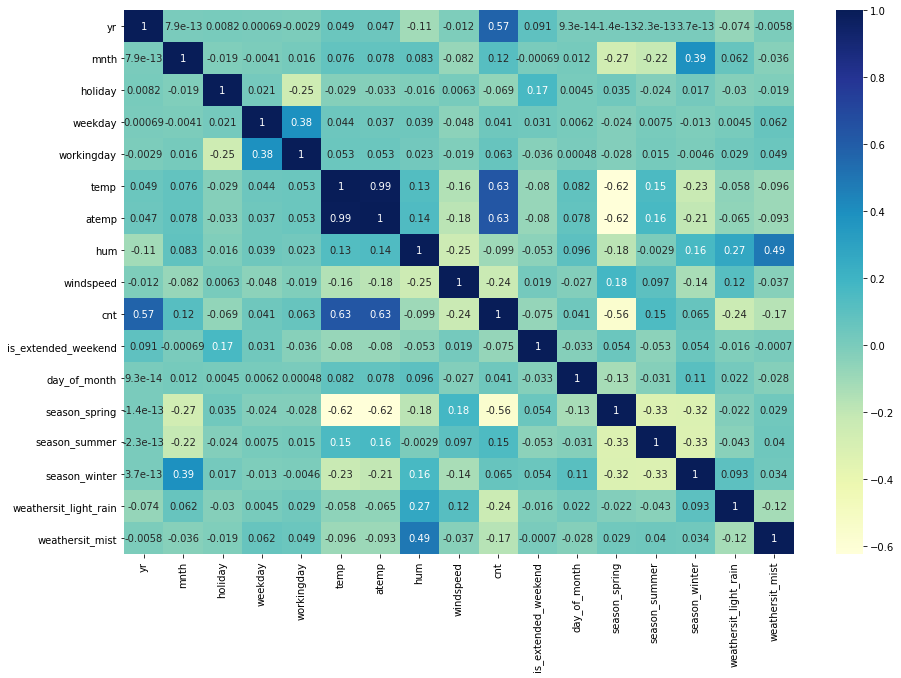

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')
plt.show()

- Interesting to see yr correlated high with cnt. 
- Also, temp and atemp are correlated well with cnt, as well as between themselves.
- So is humidity with mist.
- Spring has decent negative correlation with cnt as well as temp.

In [26]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [29]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.params

const                    2771.344037
yr                       2057.461104
mnth                     -127.681731
holiday                  -576.410036
weekday                   116.451240
workingday                  3.494601
temp                     1208.933116
atemp                    2964.066507
hum                     -1203.093215
windspeed               -1238.198383
is_extended_weekend     -1869.496610
day_of_month             -159.401533
season_spring            -903.777302
season_summer             216.342615
season_winter             637.323298
weathersit_light_rain   -1929.314404
weathersit_mist          -433.408644
dtype: float64

In [30]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     169.1
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.32e-203
Time:                        19:38:30   Log-Likelihood:                -4738.5
No. Observations:                 584   AIC:                             9511.
Df Residuals:                     567   BIC:                             9585.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2771.3440    306.064      9.055      0.000    2170.186    3372.503
yr                     2057.4611     69.558     29.579      0.000    1920.838    2194.085
mnth                   -127.6817    120.619     -1.059      0.290    -364.596     109.233
holiday                -576.4100    209.260     -2.755      0.006    -987.429    -165.391
weekday                 116.4512    113.145      1.029      0.304    -105.784     338.686
workingday                3.4946     81.849      0.043      0.966    -157.270     164.260
temp                   1208.9331   2001.016      0.604      0.546   -2721.376    5139.243
atemp                  2964.0665   2110.343      1.405      0.161   -1180.977    7109.110
hum                   -1203.0932    313.655     -3.836      0.000   -1819.161    -587.025
windspeed             -1238.1984    231.381     -5.351      0.000   -1692.667    -783.730
is_extended_weekend   -1869.4966    381.715     -4.898      0.000   -2619.244   -1119.749
day_of_month           -159.4015    117.784     -1.353      0.176    -390.747      71.944
season_spring          -903.7773    167.552     -5.394      0.000   -1232.876    -574.679
season_summer           216.3426    113.693      1.903      0.058      -6.968     439.654
season_winter           637.3233    141.310      4.510      0.000     359.768     914.879
weathersit_light_rain -1929.3144    218.688     -8.822      0.000   -2358.852   -1499.777
weathersit_mist        -433.4086     90.464     -4.791      0.000    -611.095    -255.722
==============================================================================
Omnibus:                       67.141   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.266
Skew:                          -0.602   Prob(JB):                     4.77e-37
Kurtosis:                       5.329   Cond. No.                         170.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
# calculate vif
vif = pd.DataFrame(
    [[var, VIF(X_train.values, i)] for i, var in enumerate(X_train.columns)],
    columns=['Features', 'VIF']
)
vif['VIF'] = vif['VIF'].round(2)
vif.sort_values(['VIF'], ascending=False)

,Features,VIF
6,atemp,1209.29
5,temp,1197.99
7,hum,27.28
8,windspeed,4.98
1,mnth,4.26
4,workingday,3.90
3,weekday,3.89
10,day_of_month,3.88
11,season_spring,3.80
13,season_winter,3.36


Let's remove 'workingday' since it has very high p-value

In [36]:
def get_sm_summary(X_tr, y_tr):
    X_train_sm = sm.add_constant(X_tr)
    lr = sm.OLS(y_tr, X_train_sm)
    lr_model = lr.fit()
    return lr_model.summary()

def calculate_vif(X_tr):
    # calculate vif
    vif = pd.DataFrame(
        [[var, VIF(X_tr.values, i)] for i, var in enumerate(X_tr.columns)],
        columns=['Features', 'VIF']
    )
    vif['VIF'] = vif['VIF'].round(2)
    return vif.sort_values(['VIF'], ascending=False)

In [37]:
X_tr = X_train.drop('workingday', axis=1)
get_sm_summary(X_tr, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     180.7
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          9.62e-205
Time:                        19:52:07   Log-Likelihood:                -4738.5
No. Observations:                 584   AIC:                             9509.
Df Residuals:                     568   BIC:                             9579.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2772.1547    305.206      9.083      0.000    2172.684    3371.626
yr                     2057.4826     69.495     29.606      0.000    1920.983    2193.982
mnth                   -127.5660    120.482     -1.059      0.290    -364.212     109.079
holiday                -578.7879    201.535     -2.872      0.004    -974.633    -182.943
weekday                 118.3232    104.213      1.135      0.257     -86.367     323.013
temp                   1205.3723   1997.520      0.603      0.546   -2718.055    5128.800
atemp                  2968.5415   2105.885      1.410      0.159   -1167.732    7104.815
hum                   -1203.1170    313.379     -3.839      0.000   -1818.640    -587.594
windspeed             -1238.2651    231.172     -5.356      0.000   -1692.322    -784.208
is_extended_weekend   -1869.9295    381.245     -4.905      0.000   -2618.751   -1121.108
day_of_month           -159.1926    117.579     -1.354      0.176    -390.135      71.749
season_spring          -903.4323    167.210     -5.403      0.000   -1231.857    -575.007
season_summer           216.3649    113.592      1.905      0.057      -6.747     439.476
season_winter           637.4242    141.166      4.515      0.000     360.153     914.696
weathersit_light_rain -1928.8838    218.263     -8.837      0.000   -2357.586   -1500.182
weathersit_mist        -433.3297     90.366     -4.795      0.000    -610.822    -255.837
==============================================================================
Omnibus:                       67.245   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.385
Skew:                          -0.603   Prob(JB):                     4.49e-37
Kurtosis:                       5.329   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
calculate_vif(X_tr)

,Features,VIF
5,atemp,1205.96
4,temp,1196.11
6,hum,27.25
7,windspeed,4.98
1,mnth,4.25
9,day_of_month,3.87
10,season_spring,3.75
12,season_winter,3.35
3,weekday,3.25
11,season_summer,2.42


'temp' is both high p-value and high VIF. Let's remove this

In [39]:
X_tr = X_tr.drop('temp', axis=1)
get_sm_summary(X_tr, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     193.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          8.13e-206
Time:                        19:52:33   Log-Likelihood:                -4738.7
No. Observations:                 584   AIC:                             9507.
Df Residuals:                     569   BIC:                             9573.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2777.9856    304.883      9.112      0.000    2179.152    3376.819
yr                     2058.0021     69.451     29.632      0.000    1921.590    2194.414
mnth                   -125.7027    120.376     -1.044      0.297    -362.137     110.732
holiday                -569.3179    200.811     -2.835      0.005    -963.739    -174.897
weekday                 120.7055    104.080      1.160      0.247     -83.723     325.134
atemp                  4227.4895    286.347     14.764      0.000    3665.063    4789.916
hum                   -1213.7284    312.710     -3.881      0.000   -1827.936    -599.521
windspeed             -1200.6886    222.503     -5.396      0.000   -1637.716    -763.661
is_extended_weekend   -1868.0000    381.018     -4.903      0.000   -2616.374   -1119.626
day_of_month           -153.7768    117.170     -1.312      0.190    -383.916      76.362
season_spring          -925.6973    162.997     -5.679      0.000   -1245.847    -605.548
season_summer           198.4173    109.568      1.811      0.071     -16.789     413.624
season_winter           611.0211    134.139      4.555      0.000     347.553     874.489
weathersit_light_rain -1917.3420    217.302     -8.823      0.000   -2344.154   -1490.530
weathersit_mist        -429.7156     90.117     -4.768      0.000    -606.718    -252.713
==============================================================================
Omnibus:                       70.244   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.405
Skew:                          -0.629   Prob(JB):                     8.15e-39
Kurtosis:                       5.372   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
calculate_vif(X_tr)

,Features,VIF
5,hum,27.19
4,atemp,15.23
6,windspeed,4.51
1,mnth,4.25
8,day_of_month,3.85
9,season_spring,3.51
3,weekday,3.25
11,season_winter,2.98
13,weathersit_mist,2.29
10,season_summer,2.23


Now removing 'mnth'

In [41]:
X_tr = X_tr.drop('mnth', axis=1)
get_sm_summary(X_tr, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     208.5
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          9.50e-207
Time:                        19:55:22   Log-Likelihood:                -4739.3
No. Observations:                 584   AIC:                             9507.
Df Residuals:                     570   BIC:                             9568.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2711.7581    298.237      9.093      0.000    2125.980    3297.536
yr                     2057.1619     69.452     29.620      0.000    1920.749    2193.575
holiday                -563.7853    200.757     -2.808      0.005    -958.099    -169.472
weekday                 122.9573    104.066      1.182      0.238     -81.442     327.357
atemp                  4217.5328    286.211     14.736      0.000    3655.376    4779.690
hum                   -1218.0925    312.707     -3.895      0.000   -1832.292    -603.893
windspeed             -1201.1062    222.520     -5.398      0.000   -1638.166    -764.046
is_extended_weekend   -1872.3728    381.025     -4.914      0.000   -2620.758   -1123.988
day_of_month           -143.5032    116.766     -1.229      0.220    -372.847      85.840
season_spring          -904.6982    161.765     -5.593      0.000   -1222.426    -586.971
season_summer           218.8032    107.823      2.029      0.043       7.024     430.582
season_winter           589.6354    132.577      4.447      0.000     329.236     850.034
weathersit_light_rain -1923.4752    217.240     -8.854      0.000   -2350.164   -1496.786
weathersit_mist        -429.6889     90.124     -4.768      0.000    -606.705    -252.673
==============================================================================
Omnibus:                       72.421   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.422
Skew:                          -0.645   Prob(JB):                     2.44e-40
Kurtosis:                       5.416   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
calculate_vif(X_tr)

,Features,VIF
4,hum,26.60
3,atemp,14.70
5,windspeed,4.47
7,day_of_month,3.84
8,season_spring,3.51
2,weekday,3.25
10,season_winter,2.74
12,weathersit_mist,2.29
9,season_summer,2.21
0,yr,2.02


In [43]:
# 'weekday'
X_tr = X_tr.drop('weekday', axis=1)
get_sm_summary(X_tr, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     225.6
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.24e-207
Time:                        19:58:46   Log-Likelihood:                -4740.0
No. Observations:                 584   AIC:                             9506.
Df Residuals:                     571   BIC:                             9563.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2784.0704    291.991      9.535      0.000    2210.562    3357.578
yr                     2056.4087     69.473     29.600      0.000    1919.954    2192.863
holiday                -561.4473    200.817     -2.796      0.005    -955.877    -167.018
atemp                  4226.1824    286.217     14.766      0.000    3664.017    4788.348
hum                   -1231.4083    312.612     -3.939      0.000   -1845.419    -617.398
windspeed             -1229.0389    221.338     -5.553      0.000   -1663.774    -794.304
is_extended_weekend   -1837.4359    380.008     -4.835      0.000   -2583.820   -1091.052
day_of_month           -143.7425    116.806     -1.231      0.219    -373.164      85.679
season_spring          -907.8693    161.798     -5.611      0.000   -1225.662    -590.077
season_summer           219.3112    107.860      2.033      0.042       7.461     431.161
season_winter           584.4481    132.550      4.409      0.000     324.103     844.794
weathersit_light_rain -1906.7920    216.856     -8.793      0.000   -2332.725   -1480.859
weathersit_mist        -419.4133     89.735     -4.674      0.000    -595.664    -243.163
==============================================================================
Omnibus:                       76.066   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.182
Skew:                          -0.680   Prob(JB):                     8.31e-42
Kurtosis:                       5.434   Cond. No.                         20.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
calculate_vif(X_tr)

,Features,VIF
3,hum,26.39
2,atemp,14.20
4,windspeed,4.47
6,day_of_month,3.83
7,season_spring,3.44
9,season_winter,2.72
11,weathersit_mist,2.28
8,season_summer,2.19
0,yr,2.02
10,weathersit_light_rain,1.35


In [45]:
# 'day_of_month'
X_tr = X_tr.drop('day_of_month', axis=1)
get_sm_summary(X_tr, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     245.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.64e-208
Time:                        20:00:00   Log-Likelihood:                -4740.8
No. Observations:                 584   AIC:                             9506.
Df Residuals:                     572   BIC:                             9558.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2731.3185    288.957      9.452      0.000    2163.772    3298.865
yr                     2055.5965     69.501     29.576      0.000    1919.088    2192.105
holiday                -563.8055    200.898     -2.806      0.005    -958.393    -169.218
atemp                  4225.7379    286.345     14.758      0.000    3663.322    4788.154
hum                   -1261.8455    311.773     -4.047      0.000   -1874.204    -649.487
windspeed             -1239.8875    221.261     -5.604      0.000   -1674.471    -805.304
is_extended_weekend   -1829.8270    380.129     -4.814      0.000   -2576.445   -1083.209
season_spring          -898.3673    161.687     -5.556      0.000   -1215.939    -580.795
season_summer           223.6656    107.850      2.074      0.039      11.835     435.496
season_winter           581.0726    132.581      4.383      0.000     320.667     841.478
weathersit_light_rain -1898.2730    216.843     -8.754      0.000   -2324.178   -1472.368
weathersit_mist        -412.1091     89.578     -4.601      0.000    -588.052    -236.166
==============================================================================
Omnibus:                       79.140   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.722
Skew:                          -0.704   Prob(JB):                     1.16e-43
Kurtosis:                       5.478   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
calculate_vif(X_tr)

,Features,VIF
3,hum,25.42
2,atemp,14.02
4,windspeed,4.41
6,season_spring,3.43
8,season_winter,2.68
10,weathersit_mist,2.26
7,season_summer,2.19
0,yr,2.02
9,weathersit_light_rain,1.34
1,holiday,1.08


Now every p-value is less than 0.05. But there are still some high vif's. Let's remove those.

In [47]:
# 'hum'
X_tr = X_tr.drop('hum', axis=1)
get_sm_summary(X_tr, y_train)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     261.7
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          3.09e-206
Time:                        20:01:17   Log-Likelihood:                -4749.0
No. Observations:                 584   AIC:                             9520.
Df Residuals:                     573   BIC:                             9568.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  2073.7893    242.148      8.564      0.000    1598.182    2549.396
yr                     2096.1491     69.692     30.077      0.000    1959.266    2233.032
holiday                -577.2136    203.549     -2.836      0.005    -977.006    -177.421
atemp                  3968.4091    282.920     14.027      0.000    3412.723    4524.095
windspeed              -991.0714    215.383     -4.601      0.000   -1414.108    -568.035
is_extended_weekend   -1785.8517    385.039     -4.638      0.000   -2542.112   -1029.591
season_spring          -943.7213    163.448     -5.774      0.000   -1264.752    -622.690
season_summer           196.2758    109.073      1.799      0.072     -17.955     410.507
season_winter           500.1606    132.813      3.766      0.000     239.301     761.020
weathersit_light_rain -2294.4975    196.066    -11.703      0.000   -2679.592   -1909.402
weathersit_mist        -621.1933     74.157     -8.377      0.000    -766.847    -475.540
==============================================================================
Omnibus:                       77.264   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.088
Skew:                          -0.694   Prob(JB):                     5.28e-42
Kurtosis:                       5.426   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
calculate_vif(X_tr)

,Features,VIF
3,windspeed,4.40
2,atemp,3.60
0,yr,2.01
5,season_spring,1.96
6,season_summer,1.82
7,season_winter,1.62
9,weathersit_mist,1.53
8,weathersit_light_rain,1.11
1,holiday,1.08
4,is_extended_weekend,1.07


Now every variable has low p-value(less than 0.05) and low VIF(less than 5)!

### Residual Analysis

In [52]:
y_train

176    5305
172    4507
142    4274
237    4661
531    7702
       ... 
369    5740
320    3053
527    5375
125    4906
265    2395
Name: cnt, Length: 584, dtype: int64

In [54]:
X_tr_sm = sm.add_constant(X_tr)
lr = sm.OLS(y_train, X_tr_sm)
lr_model = lr.fit()
preds_tr = lr_model.predict(X_tr_sm)


176    4877.988626
172    5004.017968
142    3907.706412
237    5015.803313
531    6792.115107
          ...     
369    6101.462702
320    2666.974560
527    5325.780196
125    4249.876061
265    4189.962928
Length: 584, dtype: float64

In [55]:
train_residuals = y_train-preds_tr

C:\Users\nkothapalli\Miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

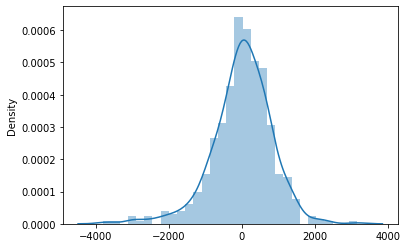

In [56]:
sns.distplot(train_residuals)

The residual distribution looks normal, centered around 0!

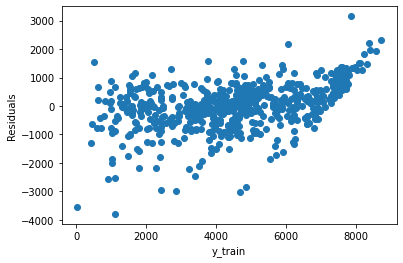

In [62]:
plt.scatter(y_train, train_residuals)
plt.ylabel('Residuals')
plt.xlabel('y_train')

plt.show()

Although the residuals are a bit higher towards very high values of y, there is no clear pattern between residual-vs-y plot

### Model Evaluation

In [63]:
X_test.describe()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,is_extended_weekend,day_of_month,season_spring,season_summer,season_winter,weathersit_light_rain,weathersit_mist
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.527397,0.501868,0.020548,0.496575,0.726027,0.548905,0.520813,0.641373,0.317939,0.006849,0.477854,0.239726,0.198630,0.253425,0.006849,0.328767
std,0.500967,0.304842,0.142354,0.342668,0.447530,0.238717,0.225822,0.132469,0.171201,0.082761,0.291127,0.428386,0.400342,0.436469,0.082761,0.471382
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.106185,0.092512,0.323237,-0.049804,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.272727,0.000000,0.166667,0.000000,0.350497,0.345078,0.547450,0.205585,0.000000,0.233333,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.545455,0.000000,0.500000,1.000000,0.571151,0.557068,0.641816,0.299461,0.000000,0.466667,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.727273,0.000000,0.833333,1.000000,0.747934,0.697353,0.740681,0.414520,0.000000,0.700000,0.000000,0.000000,0.750000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.984424,0.951946,0.951157,0.857377,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We have scaled features already. Let's start inference

In [64]:
X_test_sm = sm.add_constant(X_test[X_tr.columns])
preds_test = lr_model.predict(X_test_sm)
preds_test.shape

(146,)

In [65]:
# calculate r2 on test
r2_score(y_true=y_test, y_pred=preds_test)

0.8177600950227761

This is very close to r2 of 0.82 on train set and the model has generalized well!

### Model Interpretation

In [67]:
# Let's analyze coefficients now to see the factors impacting the bike demand the most.
params = lr_model.params
params

const                    2073.789264
yr                       2096.149078
holiday                  -577.213597
atemp                    3968.409115
windspeed                -991.071446
is_extended_weekend     -1785.851657
season_spring            -943.721331
season_summer             196.275823
season_winter             500.160551
weathersit_light_rain   -2294.497459
weathersit_mist          -621.193308
dtype: float64

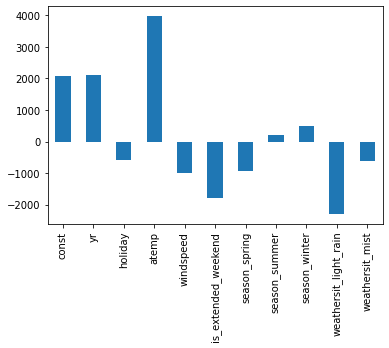

In [70]:
params.plot.bar()
plt.show()

- We observe that 'atemp' has the biggest positive influence on the demand, followed by year.
- light_rain and extended_weekend also have big influence (albeit negative)

In [72]:
!python --version

Python 3.9.1
